## MLP Version 2

This version is modeled off of collaborative filtering methodology. It simply takes in user_id and recipe_code in order to predict stars. The ids go through embedding layers in order for the model to learn their relationship.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

### Data Processing

In [5]:
# Load the data from CSV
df = pd.read_csv("recipe_review_data.csv")

# Count reviews per user
review_counts = df.groupby('user_id').size()
# Get user_ids with more than 5 reviews
users_over_5 = review_counts[review_counts >= 5].index
# Filter the DataFrame to include only these users
df = df[df['user_id'].isin(users_over_5)]
print("Data preview:")
df.head()

Data preview:


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
27,27,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_432496,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622648873,0,4,0,5,329,EXCELLENT RECIPE!! This will be on regular rot...
79,79,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_424088,u_1oKVchl3LINh51liAWR6aZjJEqJ,jeanemed,20,1622718447,0,0,0,5,100,Very good. I wonder if it once had cream chees...
83,83,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_423740,u_1oKVyRJPymM0gqQgaXO2kbAAFwF,skipperstrucking,1,1622718475,0,0,0,5,100,Very good recipe. you do need to add a couple...
111,111,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_312758,u_1oKVZzipo1u8lcqQzDUcw4UBn9e,2124arizona,20,1622717860,0,0,0,5,100,"This is great on a chilly, overcast day. My br..."
116,116,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_115610,u_1oKVa5Jp2jnBvdroQIjCdFJTlja,pajamaangel,10,1622716916,0,0,0,5,100,An extraordinary recipe. We all loved this ch...


In [6]:
# Map user and recipe ids to unique integer indices (for embeddings)
user_ids = df['user_id'].unique().tolist()
recipe_ids = df['recipe_code'].unique().tolist()

user_to_index = {user: idx for idx, user in enumerate(user_ids)}
recipe_to_index = {recipe: idx for idx, recipe in enumerate(recipe_ids)}

df['user_idx'] = df['user_id'].map(user_to_index)
df['recipe_idx'] = df['recipe_code'].map(recipe_to_index)

num_users = len(user_ids)
num_recipes = len(recipe_ids)

print(f"Number of users: {num_users}")
print(f"Number of recipes: {num_recipes}")

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


Number of users: 59
Number of recipes: 98


In [55]:
class RecipeRatingDataset(Dataset):
    def __init__(self, df):
        self.users = df['user_idx'].values
        self.recipes = df['recipe_idx'].values
        self.ratings = df['stars'].values.astype(np.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return {
            'user': torch.tensor(self.users[idx], dtype=torch.long),
            'recipe': torch.tensor(self.recipes[idx], dtype=torch.long),
            'rating': torch.tensor(self.ratings[idx], dtype=torch.float)
        }

# Create dataset objects
train_dataset = RecipeRatingDataset(train_df)
test_dataset = RecipeRatingDataset(test_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

### Define the Model

In [57]:
class NCFModel(nn.Module):
    def __init__(self, num_users, num_recipes, embedding_dim=50):
        super(NCFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.recipe_embedding = nn.Embedding(num_recipes, embedding_dim)

        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)

        self.relu = nn.ReLU()

    def forward(self, user, recipe):
        user_emb = self.user_embedding(user)
        recipe_emb = self.recipe_embedding(recipe)
        user_emb = user_emb.view(user_emb.size(0), -1)
        recipe_emb = recipe_emb.view(recipe_emb.size(0), -1)

        x = torch.cat([user_emb, recipe_emb], dim=1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        # Apply scaled sigmoid: output between 1 and 5
        x = 1 + 4 * torch.sigmoid(self.output_layer(x))
        return x.squeeze()

In [58]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = NCFModel(num_users=num_users, num_recipes=num_recipes, embedding_dim=50)
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

NCFModel(
  (user_embedding): Embedding(188, 50)
  (recipe_embedding): Embedding(100, 50)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)


### Train the Model and Evaluate

Epoch 1/100 - Train Loss: 2.1881, Test Loss: 0.8410
Epoch 2/100 - Train Loss: 0.9020, Test Loss: 0.8061
Epoch 3/100 - Train Loss: 0.8687, Test Loss: 0.7486
Epoch 4/100 - Train Loss: 0.7911, Test Loss: 0.7352
Epoch 5/100 - Train Loss: 0.7491, Test Loss: 0.7214
Epoch 6/100 - Train Loss: 0.7104, Test Loss: 0.7123
Epoch 7/100 - Train Loss: 0.6603, Test Loss: 0.7032
Epoch 8/100 - Train Loss: 0.6460, Test Loss: 0.6963
Epoch 9/100 - Train Loss: 0.6087, Test Loss: 0.6798
Epoch 10/100 - Train Loss: 0.5773, Test Loss: 0.6676
Epoch 11/100 - Train Loss: 0.5248, Test Loss: 0.6564
Epoch 12/100 - Train Loss: 0.4635, Test Loss: 0.6292
Epoch 13/100 - Train Loss: 0.4179, Test Loss: 0.6071
Epoch 14/100 - Train Loss: 0.3802, Test Loss: 0.5817
Epoch 15/100 - Train Loss: 0.3340, Test Loss: 0.5903
Epoch 16/100 - Train Loss: 0.2810, Test Loss: 0.5811
Epoch 17/100 - Train Loss: 0.2708, Test Loss: 0.5616
Epoch 18/100 - Train Loss: 0.2116, Test Loss: 0.5435
Epoch 19/100 - Train Loss: 0.2021, Test Loss: 0.5568
Ep

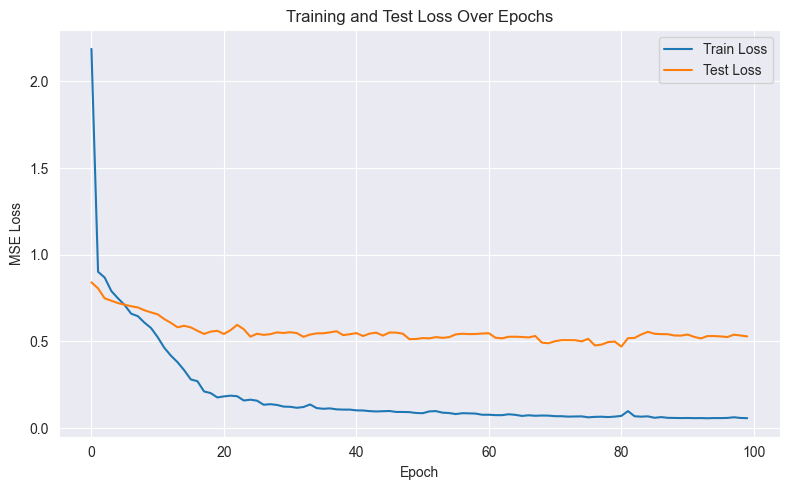

In [59]:
n_epochs = 100
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        user = batch['user'].to(device)
        recipe = batch['recipe'].to(device)
        rating = batch['rating'].to(device)

        optimizer.zero_grad()
        outputs = model(user, recipe)
        loss = criterion(outputs, rating)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            user = batch['user'].to(device)
            recipe = batch['recipe'].to(device)
            rating = batch['rating'].to(device)

            outputs = model(user, recipe)
            loss = criterion(outputs, rating)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Recommendation Functionality

In [60]:
def recommend_recipes(model, user_identifier, df, top_n=5):
    """
    Recommend top_n recipes for a given user identifier (user_id or user_name) by
    referencing the original DataFrame to derive necessary mappings.

    Returns:
        A list of tuples: (recipe_id, recipe_name, predicted_rating)
    """
    # set auto user for testing purposes
    if user_identifier == None or user_identifier == "":
        user_identifier = "Jeri326"
    # Determine whether the identifier is a user_id or user_name
    if user_identifier in df['user_id'].unique():
        user_id = user_identifier
    elif 'user_name' in df.columns and user_identifier in df['user_name'].unique():
        user_id = df.loc[df['user_name'] == user_identifier, 'user_id'].iloc[0]
    else:
        print("User identifier not found in the data.")
        return []

    # Build mappings on the fly using the original DataFrame
    user_to_index = {u: i for i, u in enumerate(df['user_id'].unique())}
    recipe_to_index = {r: i for i, r in enumerate(df['recipe_code'].unique())}
    index_to_recipe = {i: r for r, i in recipe_to_index.items()}

    # Build a mapping from recipe_id to recipe_name if available; otherwise, fallback to string version of recipe_id
    if 'recipe_name' in df.columns:
        recipe_id_to_name = df.drop_duplicates(subset=['recipe_code']).set_index('recipe_code')['recipe_name'].to_dict()
    else:
        recipe_id_to_name = {r: str(r) for r in df['recipe_id'].unique()}

    # Ensure the user exists in the mapping
    if user_id not in user_to_index:
        print("User id not found in mapping.")
        return []

    user_idx = user_to_index[user_id]

    # Prepare a tensor of all recipe indices and a tensor of the user index repeated accordingly
    all_recipe_indices = torch.arange(len(recipe_to_index)).to(device)
    user_tensor = torch.full((all_recipe_indices.shape[0],), user_idx, dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(user_tensor, all_recipe_indices).cpu().numpy()

    # Find the indices of the top_n predicted ratings (highest first)
    top_indices = np.argsort(predictions)[-top_n:][::-1]

    recommendations = []
    for idx in top_indices:
        rec_recipe_id = index_to_recipe.get(idx, "Unknown")
        rec_recipe_name = recipe_id_to_name.get(rec_recipe_id, "Unknown")
        rec_rating = predictions[idx]
        recommendations.append((rec_recipe_id, rec_recipe_name, rec_rating))

    return recommendations


In [61]:
# use function
user_input = input("Enter a user id or user name: ")
recommendations = recommend_recipes(model, user_input, df, top_n=5)

print(f"\nTop 5 recipe recommendations for user '{user_input}':")
for recipe_id, recipe_name, rating in recommendations:
    print(f"Recipe ID: {recipe_id}, Recipe Name: {recipe_name} Predicted Rating: {rating:.2f}")

# compare to actual user top
if user_input == None or user_input == "":
        user_identifier = "Jeri326"
if user_input in df['user_id'].unique():
    user_id = user_input
elif 'user_name' in df.columns and user_input in df['user_name'].unique():
    user_id = df.loc[df['user_name'] == user_input, 'user_id'].iloc[0]

actual_top = df[df['user_id'] == user_id].sort_values('stars', ascending=False)
actual_top.head()


Top 5 recipe recommendations for user 'ahmom':
Recipe ID: 26937, Recipe Name: Pineapple Pudding Cake Predicted Rating: 5.00
Recipe ID: 1196, Recipe Name: Pumpkin Bread Predicted Rating: 5.00
Recipe ID: 12003, Recipe Name: Traditional Lasagna Predicted Rating: 5.00
Recipe ID: 7752, Recipe Name: Chocolate Caramel Candy Predicted Rating: 5.00
Recipe ID: 14600, Recipe Name: Buttery Cornbread Predicted Rating: 5.00


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text,user_idx,recipe_idx
27,27,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_432496,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622648873,0,4,0,5,329,EXCELLENT RECIPE!! This will be on regular rot...,0,0
762,108,2,3309,Best Ever Banana Bread,sp_aUSaElGf_3309_c_331695,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622718003,0,0,0,5,100,This turned out wonderfully. I used bananas th...,0,1
4758,302,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_139670,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622717031,0,0,0,5,100,excellent!,0,11
6356,162,18,2872,Stuffed Pepper Soup,sp_aUSaElGf_2872_c_185471,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622717251,0,0,0,5,100,I LOVE this soup!!,0,17
6395,201,18,2872,Stuffed Pepper Soup,sp_aUSaElGf_2872_c_139758,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622717031,0,0,0,5,100,EXCELLENT!,0,17
